In [1]:
from pyspark import SparkContext, SparkConf
conf=SparkConf().setMaster('yarn').setAppName("Lab5")
conf.set("spark.executor.memory", "4g")
conf.set("spark.driver.memory", "4g")
conf.set("spark.cores.max", "2")
conf.set("spark.yarn.dist.archives","spark.tar.gz#environment")
import os
os.environ['PYSPARK_PYTHON'] = "environment/bin/python"
sc=SparkContext(conf=conf)
import numpy as np

In [2]:
sc

<SparkContext master=yarn appName=Lab5>

# DATA PREPARATION

In [3]:
# read the data
rawRDD = (sc.textFile("hdfs://yarnmaster:9000/country_data",8))

In [4]:
# Display the header of the data
rawRDD.take(1)

['country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp']

In [5]:
%%time
# remove header and show the first 05 rows
tagsheader = rawRDD.first()
header = sc.parallelize([tagsheader])
nonHeaderRDD = rawRDD.subtract(header)
print(nonHeaderRDD.take(5))

['Bosnia and Herzegovina,6.9,29.7,11.1,51.3,9720,1.4,76.8,1.31,4610', 'Comoros,88.2,16.5,4.51,51.7,1410,3.87,65.9,4.75,769', '"Congo, Dem. Rep.",116,41.1,7.91,49.6,609,20.8,57.5,6.54,334', 'Costa Rica,10.2,33.2,10.9,35,13000,6.57,80.4,1.92,8200', 'Egypt,29.1,21.3,4.66,26.6,9860,10.1,70.5,3.19,2600']
CPU times: user 24.3 ms, sys: 0 ns, total: 24.3 ms
Wall time: 2.36 s


In [6]:
def splitFunc(x):
    if x[0] == '"':
        split_1 = x.split('"')
        splitted = [10]
        splitted[0] = split_1[1]
        splitted.extend(split_1[2].split(',')[1:])
    else:
        splitted = x.split(',')
        
    for i in range (1,10):
        splitted[i] = float(splitted[i])
    return splitted

splittedRDD = nonHeaderRDD.map(splitFunc)
dataWithCountry = splittedRDD.collect()
dataWithCountry[:5]

[['Bosnia and Herzegovina',
  6.9,
  29.7,
  11.1,
  51.3,
  9720.0,
  1.4,
  76.8,
  1.31,
  4610.0],
 ['Comoros', 88.2, 16.5, 4.51, 51.7, 1410.0, 3.87, 65.9, 4.75, 769.0],
 ['Congo, Dem. Rep.', 116.0, 41.1, 7.91, 49.6, 609.0, 20.8, 57.5, 6.54, 334.0],
 ['Costa Rica', 10.2, 33.2, 10.9, 35.0, 13000.0, 6.57, 80.4, 1.92, 8200.0],
 ['Egypt', 29.1, 21.3, 4.66, 26.6, 9860.0, 10.1, 70.5, 3.19, 2600.0]]

In [7]:
data = []
country = []
for row in dataWithCountry:
    data.append(row[1:])
    country.append(row[0])
data[0:5]

[[6.9, 29.7, 11.1, 51.3, 9720.0, 1.4, 76.8, 1.31, 4610.0],
 [88.2, 16.5, 4.51, 51.7, 1410.0, 3.87, 65.9, 4.75, 769.0],
 [116.0, 41.1, 7.91, 49.6, 609.0, 20.8, 57.5, 6.54, 334.0],
 [10.2, 33.2, 10.9, 35.0, 13000.0, 6.57, 80.4, 1.92, 8200.0],
 [29.1, 21.3, 4.66, 26.6, 9860.0, 10.1, 70.5, 3.19, 2600.0]]

Normalization

In [8]:
from sklearn.preprocessing import StandardScaler
scaler =StandardScaler()
data_scaled= np.around(scaler.fit_transform(data), 3)


In [9]:
Nof_clusters = 6 # I found that 6 is better for this small dataset
dataWithCountry = []
scaledRDD = sc.parallelize(data_scaled,8)
### We only care about 3 features gdpp, child_mort, income
scaledRDD = scaledRDD.map(lambda x: np.array([x[0],x[4],x[8]]))
data_scaled = scaledRDD.collect()

# DISTRIBUTED KMEANS
ref: https://github.com/apache/spark/blob/master/examples/src/main/python/kmeans.py

In [10]:
def closestPoint(p, centers):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centers)):
        tempDist = np.linalg.norm(p - centers[i])
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return bestIndex

In [11]:
centroidsList = scaledRDD.takeSample(False, Nof_clusters, 1)

In [12]:
tempDist = 1.0
convergeDist = 0.1
while tempDist > convergeDist:
    closest = scaledRDD.map(
            lambda p: (closestPoint(p, centroidsList), (p, 1)))
    pointStats = closest.reduceByKey(
            lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
    newPoints = pointStats.map(
            lambda st: (st[0], st[1][0] / st[1][1])).collect()

    tempDist = sum(np.sum((centroidsList[iK] - p) ** 2) for (iK, p) in newPoints)

    for (iK, p) in newPoints:
            centroidsList[iK] = p


In [13]:
centroidsList

[array([-0.7485,  2.8215,  1.4165]),
 array([-0.77423529,  0.73641176,  0.55317647]),
 array([-0.8305 ,  3.459  ,  3.91075]),
 array([-0.40370886, -0.30322785, -0.3856962 ]),
 array([-0.844875 ,  1.2476875,  1.814    ]),
 array([ 1.38055319, -0.71604255, -0.62270213])]

In [14]:
closest.take(2)

[(3, (array([-0.78 , -0.386, -0.457]), 1)),
 (5, (array([ 1.242, -0.819, -0.667]), 1))]

# BFR

In [15]:
####init centroids
import random
def getMinDistance(point, ini_points):
    min_dis = 100000
    for ip in ini_points:
        dis = np.linalg.norm(point-ip)
        if dis<8 and dis>4 and dis < min_dis:
            min_dis = dis
    return min_dis

def Euclidean_Clustering(centroids, x):
    cluster_index = -1
    min_distance = 10000
    for i, centroid in enumerate(centroids):
        distance = np.linalg.norm(x-centroid)
        if distance < euclidean_threshold and distance < min_distance:
            min_distance = distance
            cluster_index = i 
    return (cluster_index, x)

def getSamplePoints(dataList, n=20):
    sampleList = []
    sampleListIndex = []
    while len(sampleList) < n:
        index = random.randint(0,len(data_scaled)-1)
        if index not in sampleListIndex:
            sampleList.append(dataList[index])
            sampleListIndex.append(index)
    return sampleList

###First pass => Init and find points in discard set
+ I want the distance nether too far (<8) nor too close (>3), to make sure that there are always more than 1 point in initCluster
+ Initial number of centroids is 8. But because the number of dataset is too small => there are always clusters that only has 1 points => Initialization failed => So I changed number of centroids to 6
+ First pass to get points that near clusters in discard set.
+ Initial euclidean_threshold = 3 but I found that 2 is better

In [16]:
print("Starting initialization phase.... This will run until every clusters have at least 2 points.")

while True:
    initCentroids = []
    discardSet = []
    euclidean_threshold = 2
    Nof_clusters_BFR = 6
    index = random.randint(0,len(data_scaled)-1)
    initCentroids.append(data_scaled[index])


    while len(initCentroids)< Nof_clusters_BFR:
        samplePointsList = getSamplePoints(data_scaled)
        max_distance = 0
        point_has_max_distance = samplePointsList[0]
        for i, point in enumerate(samplePointsList):
            min_distance_to_cluster = getMinDistance(point, initCentroids)
            if min_distance_to_cluster<8 and min_distance_to_cluster > max_distance:
                max_distance = min_distance_to_cluster
                point_has_max_distance = point    
        initCentroids.append(point_has_max_distance)

    clusteredRDD = scaledRDD.map(lambda x: Euclidean_Clustering(initCentroids,x))
    
    errorInit = False
    for i in range (Nof_clusters_BFR):
        cluster = clusteredRDD.filter(lambda x: x[0]==i).collect()
        if len(cluster) < 2:
            errorInit = True
            print("Init failed")
            break
        else:
            discardSet.append(cluster)
    if not errorInit:
        break
    
nonDiscardedRDD = clusteredRDD.filter(lambda x: x[0]==-1)
print("Number of nonDiscarded points: " + str(nonDiscardedRDD.count()))

Starting initialization phase.... This will run until every clusters have at least 2 points.
Init failed
Init failed
Init failed
Init failed
Number of nonDiscarded points: 85


#### Update Discarded centroids

In [17]:
#Cluster = {sum:, sumq:, n:}
def update_ClusterList(clusterList, new_candidates):
    for i,setOfPoints in enumerate(new_candidates):
        clusterList[i]["sum"] = getSum(setOfPoints)
        clusterList[i]["sumQ"] = getSumQ(setOfPoints)
        clusterList[i]["n"] = len(setOfPoints)
    return clusterList
            
def getSum(pointList):
    s = pointList[0][1]
    for i in range(1, len(pointList)):
        s = s + pointList[i][1]
    return s
        
    
def getSumQ(pointList):
    s = (pointList[0][1])**2
    for i in range(1, len(pointList)):
        sq = (pointList[i][1])**2
        s = s + sq
    return s

In [18]:
discardClusterList = [] #each cluster represented by {"Sum", "SumQ", "n"}
for i in range(Nof_clusters_BFR):
    discardClusterList.append({"sum":0, "sumQ":0, "n":0})

discardClusterList = update_ClusterList(discardClusterList, discardSet)

In [19]:
#Update the centroids for later use
discardCentroids = [discardClusterList[i]['sum']/discardClusterList[i]['n'] for i in range(len(discardClusterList))]

### FIND COMPRESS SET AND RETAIN SET
+ Generate 3*k minicentroids
+ Find compress clusters - Update compress cluster
+ the remained are in remain set

In [20]:
nonDiscardedRDD2 = nonDiscardedRDD.map(lambda x: x[1])
noNonDiscarded = nonDiscardedRDD2.count()
miniCentroids = nonDiscardedRDD2.takeSample(False, min(Nof_clusters*2, noNonDiscarded) , 1)

In [21]:
clusterRDD2 = nonDiscardedRDD2.map(lambda x: Euclidean_Clustering(miniCentroids,x))
retainSet = clusterRDD2.filter(lambda x: x[0]==-1).map(lambda x: x[1]).collect()
print("Number of remained points: ", len(retainSet))

Number of remained points:  2


#### Update mini centroids

In [22]:
compressSet = []
#count for minicluster that only has more than 1 points
for i in range (min(Nof_clusters*2, noNonDiscarded)):
    cluster = clusterRDD2.filter(lambda x: x[0]==i).collect()
    if len(cluster) > 1:
        compressSet.append(cluster)
    else:
        retainSet.append(cluster[0][1]) #if has only 1 point -> move to retain set
print(len(compressSet))
print(len(retainSet))

11
3


In [23]:
compressClusterList = [] #each cluster represented by {"Sum", "SumQ", "n"}
for i in range(len(compressSet)):
    compressClusterList.append({"sum":0, "sumQ":0, "n":0})

compressClusterList = update_ClusterList(compressClusterList, compressSet)

#### Now we have discardClusterList, compressClusterList and retainSet

### Merge retainSet with the closest cluster
+ because the number of points is small so I just find the closest cluster => no need to use mahalabonis factor

In [24]:
import math
mahalanobis_factor = 3
MAHA_THRESH = mahalanobis_factor * math.sqrt(len(discardSet[0][1][1]))
def mahalanobis_dist(cluster, point):
    n = cluster["n"]
    centroids = cluster["sum"]/n
    std = np.sqrt(cluster["sumQ"]/n - centroids**2)
    temp_std = []
    for i in std:
        if i == 0:
            temp_std.append(1)
        else:
            temp_std.append(i)
    temp_std = np.array(temp_std)
    dist = math.sqrt(np.sum((p-centroids/temp_std)**2))
    return dist
def Euclidean_dist(cluster, point):
    n = cluster["n"]
    centroids = cluster["sum"]/n
    dist = np.linalg.norm(p-centroids)
    return dist

def updateClusterPoint(cluster, point):
    cluster["sum"] = cluster["sum"] + np.array(point)
    cluster["sumQ"] = cluster["sumQ"] + np.array(point)**2
    cluster["n"] +=1
    return cluster
    

### I tried with Mahalanobis distance but the result got worse than Kmeans

In [25]:
discardClusterList2 = discardClusterList
compressClusterList2 = compressClusterList
for i, point in enumerate(retainSet):
    minDist = 10000
    index = 0
    flag = 0
    print(i)
    for j, cluster in enumerate(compressClusterList2):
        dist = mahalanobis_dist(cluster, point)
        if dist < minDist:
            flag = 1
            minDist = dist
            index = j
    for j, cluster in enumerate(discardClusterList2):
        dist = mahalanobis_dist(cluster, point)
        if dist < minDist:
            flag = 2
            minDist = dist
            index = j
    if flag == 1:
        print("updated to compress " + str(index), "distance", minDist)
        compressClusterList2[index] = updateClusterPoint(compressClusterList2[index], point)
    elif flag == 2:
        print("updated to discard " + str(index), "distance", minDist)
        discardClusterList2[index] = updateClusterPoint(discardClusterList2[index], point)

0
updated to discard 0 distance 4.384702492169239
1
updated to discard 0 distance 0.4615306864377787
2
updated to discard 0 distance 0.39334275070818164


#### Merge compress set with itself and with discard set

In [26]:
def calculate_merge_factor(cluster1, cluster2):
    s = cluster1['sum'] + cluster2['sum']
    sq = cluster1['sumQ'] + cluster2['sumQ']
    n = cluster1['n'] + cluster2['n']
    stdQ_1 = np.sum(cluster1['sumQ']/cluster1['n']-(cluster1['sum']/cluster1['n'])**2)
    stdQ_2 = np.sum(cluster2['sumQ']/cluster2['n']-(cluster2['sum']/cluster2['n'])**2)
    stdQ_merge = np.sum(sq/n-(s/n)**2)
    factor = stdQ_merge/(stdQ_1+stdQ_2)
    return factor, s, sq, n

### merge all close cluster until there are only 6 left 

In [27]:
for i in range(len(compressClusterList2)):
    discardClusterList2.append(compressClusterList2[i])
print(len(discardClusterList2))

17


In [28]:
remainedDiscardClusters2 = [True for _ in range(len(discardClusterList2))]
num_ele_left = len(discardClusterList2)
thresh = 0.5
while (num_ele_left > 6):
    print("Thresh:", thresh)
    for i in range(len(discardClusterList2)-1):
        if not remainedDiscardClusters2[i]:
            continue
        min_factor = 10000
        index = 0
        updateS = 0
        updateSQ = 0
        updateN = 0
        for j in range (i+1,len(discardClusterList2)):
            if not remainedDiscardClusters2[j]:
                continue
            factor, s, sq, n = calculate_merge_factor(discardClusterList2[i], discardClusterList2[j])
            if factor <= thresh and factor< min_factor:
                min_factor = factor
                index = j
                updateS = s
                updateSQ = sq
                updateN = n
        if min_factor <= thresh:
            print("updated discard", i, "to discard ", str(index))
            discardClusterList2[index]['sum'] = s
            discardClusterList2[index]['sumQ'] = sq
            discardClusterList2[index]['n'] = n
            remainedDiscardClusters2[i] = False
            num_ele_left -= 1
            
        if num_ele_left == 6:
            break
    thresh+=0.1

BFRCluster = [discardClusterList2[i] for i in range(len(discardClusterList2)) if remainedDiscardClusters2[i]]

Thresh: 0.5
Thresh: 0.6
Thresh: 0.7
updated discard 8 to discard  10
updated discard 10 to discard  12
updated discard 12 to discard  15
Thresh: 0.7999999999999999
updated discard 15 to discard  16
Thresh: 0.8999999999999999
updated discard 7 to discard  9
updated discard 9 to discard  16
Thresh: 0.9999999999999999
updated discard 0 to discard  16
updated discard 1 to discard  16
updated discard 6 to discard  16
updated discard 11 to discard  16
updated discard 13 to discard  16


### I calculate if the centroids in BFR are near with those from Kmeans++
-> It's actually close and it's pretty worse than Kmeans++
-> Maybe there are some dump logic errors in my code

In [29]:
BFRCentroids = []
for cluster in BFRCluster:
    BFRCentroids.append(cluster['sum']/cluster['n'])
for i in range (len(BFRCentroids)):
    min_dis = 100000
    for j in range (6):
        dis = np.linalg.norm(BFRCentroids[i]-centroidsList[j])
        if dis < min_dis:
            min_dis = dis
    print(min_dis)

0.44041825380114497
0.0
0.3423360344799714
1.2988352715028952
0.4661042695120764
0.5200132976579322


In [30]:
###Clustering every point:
####Use euclidean I get better result than mahalanobis
closestBFR = scaledRDD.map(
            lambda p: (closestPoint(p, BFRCentroids), (p, 1)))

### Visualization of Kmeans++

In [31]:
import matplotlib.pyplot as plt
from matplotlib  import cm

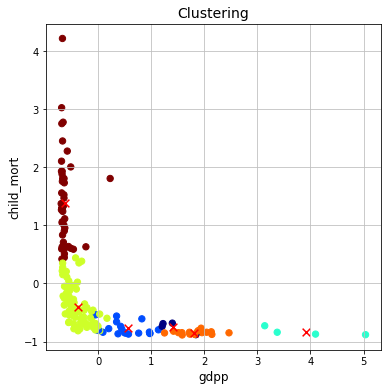

In [32]:
#gdpp, child_mort
x = closest.map(lambda x: x[1][0][2]).collect() ##gdpp
y = closest.map(lambda x: x[1][0][0]).collect() ##child_mort
cluster = closest.map(lambda x: x[0]).collect()
centroid_x = [x[2] for x in centroidsList]
centroid_y = [x[0] for x in centroidsList]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("Clustering",fontsize=14)
ax.set_xlabel("gdpp",fontsize=12)
ax.set_ylabel("child_mort",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# points coordinates

ax.scatter(x,y,s=40,c=cluster, marker = 'o', cmap = cm.jet )

ax.scatter(centroid_x,centroid_y,s=60, marker = 'x', color="red",cmap = cm.jet )

plt.show()

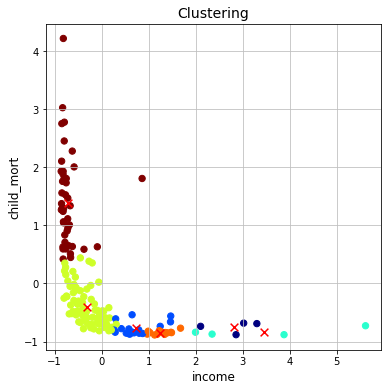

In [33]:
#income, child_mort
x = closest.map(lambda x: x[1][0][1]).collect() ##income
y = closest.map(lambda x: x[1][0][0]).collect() ##child_mort
cluster = closest.map(lambda x: x[0]).collect()
centroid_x = [x[1] for x in centroidsList]
centroid_y = [x[0] for x in centroidsList]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("Clustering",fontsize=14)
ax.set_xlabel("income",fontsize=12)
ax.set_ylabel("child_mort",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# points coordinates

ax.scatter(x,y,s=40,c=cluster, marker = 'o', cmap = cm.jet )

ax.scatter(centroid_x,centroid_y,s=60, marker = 'x', color="red",cmap = cm.jet )

plt.show()

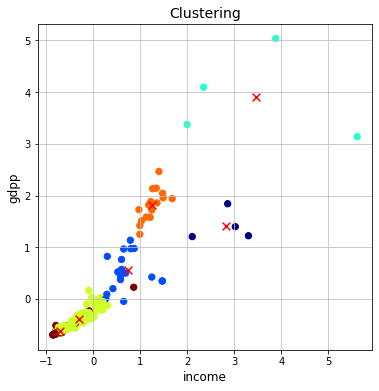

In [34]:
#income, gdpp
x = closest.map(lambda x: x[1][0][1]).collect() ##income
y = closest.map(lambda x: x[1][0][2]).collect() ##gdpp
cluster = closest.map(lambda x: x[0]).collect()
centroid_x = [x[1] for x in centroidsList]
centroid_y = [x[2] for x in centroidsList]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("Clustering",fontsize=14)
ax.set_xlabel("income",fontsize=12)
ax.set_ylabel("gdpp",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# points coordinates

ax.scatter(x,y,s=40,c=cluster, marker = 'o', cmap = cm.jet )

ax.scatter(centroid_x,centroid_y,s=60, marker = 'x', color="red",cmap = cm.jet )

plt.show()

### Visualization of BFR++

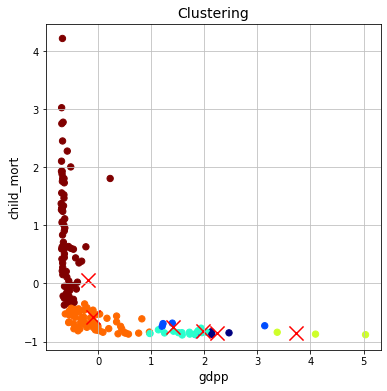

In [35]:
#gdpp, child_mort
x = closestBFR.map(lambda x: x[1][0][2]).collect() ##gdpp
y = closestBFR.map(lambda x: x[1][0][0]).collect() ##child_mort
cluster = closestBFR.map(lambda x: x[0]).collect()
centroid_x = [x[2] for x in BFRCentroids]
centroid_y = [x[0] for x in BFRCentroids]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("Clustering",fontsize=14)
ax.set_xlabel("gdpp",fontsize=12)
ax.set_ylabel("child_mort",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# points coordinates

ax.scatter(x,y,s=40,c=cluster, marker = 'o', cmap = cm.jet )

ax.scatter(centroid_x,centroid_y,s=200, marker = 'x', color="red",cmap = cm.jet )

plt.show()

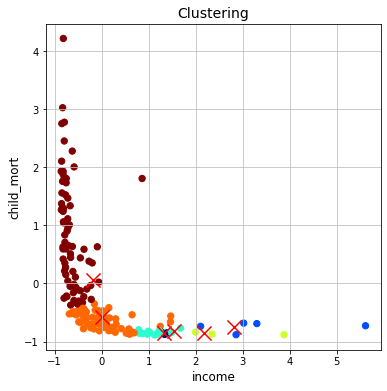

In [36]:
##income, child_mort
x = closestBFR.map(lambda x: x[1][0][1]).collect() ##income
y = closestBFR.map(lambda x: x[1][0][0]).collect() ##child_mort
cluster = closestBFR.map(lambda x: x[0]).collect()
centroid_x = [x[1] for x in BFRCentroids]
centroid_y = [x[0] for x in BFRCentroids]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("Clustering",fontsize=14)
ax.set_xlabel("income",fontsize=12)
ax.set_ylabel("child_mort",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# points coordinates

ax.scatter(x,y,s=40,c=cluster, marker = 'o', cmap = cm.jet )

ax.scatter(centroid_x,centroid_y,s=200, marker = 'x', color="red",cmap = cm.jet )

plt.show()

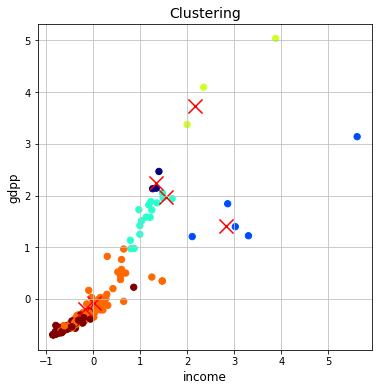

In [37]:
##income, gdpp
x = closestBFR.map(lambda x: x[1][0][1]).collect() ##income
y = closestBFR.map(lambda x: x[1][0][2]).collect() ##gdpp
cluster = closestBFR.map(lambda x: x[0]).collect()
centroid_x = [x[1] for x in BFRCentroids]
centroid_y = [x[2] for x in BFRCentroids]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("Clustering",fontsize=14)
ax.set_xlabel("income",fontsize=12)
ax.set_ylabel("gdpp",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# points coordinates

ax.scatter(x,y,s=40,c=cluster, marker = 'o', cmap = cm.jet )

ax.scatter(centroid_x,centroid_y,s=200, marker = 'x', color="red",cmap = cm.jet )

plt.show()